# 심층학습 (Deep Learning)
## 실습05 - 합성곱 신경망(2) Transfer_Learning 
### 201810793 이연우

### GitHub
https://github.com/Nunu-0/Deep-Learning

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 1. Settings
### 1) Important reauired libraries

In [31]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt

from google.colab import files
src = list(files.upload().values())[0]
open('utils.py','wb').write(src)
import utils # 교수님이 작성한 코드

Saving utils.py to utils (5).py


### 2) Hyperparameter

In [32]:
batch_size = 16 #64 #1
learning_rate = 0.0001
epoch = 20 

n_node = 1024 # customized last layer 의 노드 수. 64, 128, 256, 512, 1024
dropratio = 0.5 #얼마나 드랍시킬 지 inverse keepratio

imgsize = 256

## 1. Data Loader
### 트레이닝 데이터

In [33]:
img_dir = './gdrive/MyDrive/DeepLearning/fruit/train'
train_data = dset.ImageFolder(img_dir, transforms.Compose([
    # 1(512)32RCrop <-- Best !!
    transforms.CenterCrop(imgsize*2), # 1. CenterCrop(512) 
    transforms.RandomCrop(imgsize),  # 3. RandomCrop
    transforms.RandomHorizontalFlip(), # 2 RandomHorizontalFlip
    
    transforms.Resize(imgsize),
    transforms.ToTensor()
    ]))
print(train_data.__len__())

train_batch = data.DataLoader(train_data, batch_size = batch_size, 
                              shuffle = True, num_workers=2)

149


### 고정된 데이터 셋
#### Validation data set
train data와 다른점은 Data obmentation 하는 부분을 넣지 않는다

In [34]:
# 2. Dev Data
img_dir = './gdrive/MyDrive/DeepLearning/fruit/val' # val로 가장 성능이 잘나오는 설정
dev_data = dset.ImageFolder(img_dir, transforms.Compose([
    # transforms.Scale(256),
    # Transforms.RandomSizedCrop(224),
    # 이미지를 리사이즈 
    transforms.CenterCrop(size=imgsize),
    transforms.Resize(imgsize),
    transforms.ToTensor()
    ]))

dev_batch = data.DataLoader(dev_data, batch_size = batch_size, 
                            shuffle = True, num_workers=2)

In [35]:
# 3. Test data
# 성능을 한번만 측정
img_dir = './gdrive/MyDrive/DeepLearning/fruit/test'
test_data = dset.ImageFolder(img_dir, transforms.Compose([
     # transforms.Scale(256),
    # Transforms.RandomSizedCrop(224),
    
    transforms.CenterCrop(size=imgsize),
    transforms.Resize(imgsize),
    transforms.ToTensor()
]))

test_batch = data.DataLoader(test_data, batch_size = batch_size, 
                             shuffle = True, num_workers=2)

In [36]:
# 데이터에 대한 정보 출력
nclass = len(train_data.classes)
print("number of classes : %d" %nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print("Training: %d, Dev: %d, Test: %d" 
      %(train_data.__len__(), dev_data.__len__(), test_data.__len__()))

# for imgs, labels in train_batch:
#     for j in range(len(img)):
#         img = transforms.TopILImage()(imgs[j])
#         plt.title("labe: %d" % labels[j])
#         plt.imshow(img)
#         plt.show()

number of classes : 3
['apple', 'banana', 'orange']
{'apple': 0, 'banana': 1, 'orange': 2}
149
Training: 149, Dev: 45, Test: 55


In [37]:
# '.ipynb_checkpoints'가 클래스로 나오는 경우, 새로운 폴더(train, val, test)를 만들어 이동 시킬 것
print(train_data.classes)
print(dev_data.classes)
print(test_data.classes)

['apple', 'banana', 'orange']
['apple', 'banana', 'orange']
['apple', 'banana', 'orange']


## 3. Model
### 1) Pretrained VGG Model

In [38]:
vgg = models.vgg19(pretrained = True) # 파이토지에서 제공하는 models,  미리 학습된 세타값들을 가져오겠다.

for name, module in vgg.named_children(): # vgg안의 레이어들 출력
    print(name)
    
print(list(vgg.children())[0]) # covolution layer
print(list(vgg.children())[-1]) # Fully Connected layer

# cnt = 0
# for i in model.children():
#     print("yhk[%d]" %cnt),
#     print(i)
#     cnt = cnt + 1

features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(

In [39]:
print(list(vgg.children())[0][0])

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


### 2) Customized Fully Model

In [40]:
base_dim = 64
fsize = imgsize/32

class MyVGG(nn.Module):#CNN
    def __init__(self):
        super(MyVGG, self).__init__()
        #[0]: features(conv), [1]: classifier(fc)
        self.layer0 = nn.Sequential(*list(vgg.children())[0]) # Convolution layer를 전부 쓴다
        
        self.layer1 = nn.Sequential(  # 뒷부분은 자신이 설정한대로 만듬
            nn.Linear(8 * base_dim * int(fsize) * int(fsize) , n_node), # 8 x 8 x 512, 1024 (이부분 주의!)
            # 아래부터는 자기 마음대로
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio), #0.3만큼 드랍
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout(dropratio),
            
            nn.Linear(n_node, nclass), # n_class: 클래스 폴더 개수 (이부분 주의!)
            
        )
        
        #weight initalization
        # 레이어1에서만 함 레이어0에서는 하지 않음 (레이어0은 학습 시킬 필요가 없음)
        for m in self.layer1.modules() :
            #print(m)
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight.data) # RELU 일 때
                m.bias.data.fill_(0)
                
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)    
                
    # model = MyVGG(), model에 input이미지를 넣었을 때 이부분이 불러짐
    def forward(self, x):
        # layer 0의 사이즈를 무식하게 프린트하여 알아낼 수 있음(batchsize, x,x,x)
        # print(x.size())
        out = self.layer0(x) # layer0를 거친 output
        # print(out.size()) # layer1의 유닛의 개수를 구할 수 있음
        out = out.view(out.size(0),-1) # 1열로 펴기
        out = self.layer1(out) # Fully Connected에 해당하는 layer1에 넣기
        return out

### 3) Model on GPU

In [41]:
model = MyVGG().cuda()

for params in model.layer0.parameters(): # layer0 학습을 안해서 gradient 계산이 필요없다.
    params.required_grad = False 

for params in model.layer1.parameters(): # layer1은 학습시킴
    params.required_grad = True

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


In [42]:
for name in model.children(): # 내 모델의 구성
    print (name)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## 4. Optimizer & Loss

In [43]:
loss_func = nn.CrossEntropyLoss() # 분류 문제
optimizer = optim.Adam(model.layer1.parameters(), lr = learning_rate) #
# import itertools
# itertools.chain(model.layer1.parameters(), model.layer2.parameters()) # 레이어 2개의 파라미터드를 optimizer로 갱신

## 5. Train

In [44]:
import utils

total_time = 0
disp_step = 10

to_train = True #switch

if (to_train == False):# 미리 학습 된 모델 불러오기
    # 구조 정보와 세타 정보 포함
    netname = './gdrive/MyDrive/DeepLearning/P05.MyModel/fruit_vgg19_19.pkl'
    model = torch.load(netname)
    
else : # train한다.
    print("3 layer, n_node : %d, dropratio: %.2f" %(n_node, dropratio))
    model.eval() #evaluation(test) mode로 바꾸기 -> dropout, batch normalization에 영향을 줌
    train_corr = utils.ComputeCorr(train_batch, model)
    dev_corr = utils.ComputeCorr(train_batch, model)
    test_corr = utils.ComputeCorr(train_batch, model)
    print("Correct of train: %.2f, dev: %.2f, test: %.2f" 
          %(train_corr, dev_corr, test_corr))
    model.train()
    
    netname = './gdrive/MyDrive/DeepLearning/P05.MyModel/fruit_vgg19'
    
    # graph 그리기
    x_epoch = []
    y_train_err = []
    y_dev_err = []
    y_test_err = []
    
    # 10번 epoch 돌 때 마다 에러율 저장
    x_epoch.append(0)
    y_train_err.append(100.0-train_corr)
    y_dev_err.append(100.0-dev_corr)
    y_test_err.append(100.0-test_corr)
    
    # 학습을 재시작 한다면
    # netname = './gdrive/MyDrive/DeepLearning/P05.MyModel/fruit_vgg19.pkl'
    # model = torch.load(netname)
    # 파라미터 학습 여부 설정
    # for params in model.layer0.parameters():
    #    params.required_grad = False
    # for params in model.layer1.parameters():
    #    params.required_grad = True
    # for i in range(34,epoch):

    # 재시작하지 않는다면, 재시작 할 때는 주석
    for i in range(epoch):
        start_time = time.time()
        print("%d.."%i),
        for img,label in train_batch:
            img = Variable(img).cuda()
            label = Variable(label).cuda()
            
            optimizer.zero_grad()
            output = model(img)
            loss = loss_func(output, label)
            loss.backward()
            optimizer.step()
            
            
        end_time = time.time()
        duration = end_time - start_time
        total_time += duration
        if (i%disp_step ==0) or (i == epoch -1): # 네트워크 데이터(세타) 백업
            torch.save(model, netname+'_%d.pkl'%i, ) # 중간에 저장한다
            print("\n[%d/%d] loss: %.3f," %(i, epoch, (loss.cpu()).data.numpy())),
            
            # 학습이 잘 되고 있는지 모니터링
            #evaluation(test) mode로 바꾸기 -> dropout, batch normalization에 영향을 줌
            model.eval()
            #train, dev, train accr
            train_corr = utils.ComputeCorr(train_batch, model)
            dev_corr = utils.ComputeCorr(dev_batch, model)
            test_corr = utils.ComputeCorr(dev_batch, model)
            print("Correct of train: %.2f, dev: %.2f, test: %.2f" %(train_corr, dev_corr, test_corr))
            model.train()
            print("time: %.2f sec..." %(total_time))
            
            # graph 그리기
            x_epoch.append(i+1)
            y_train_err.append(100.0-train_corr)
            y_dev_err.append(100.0-dev_corr)
            y_test_err.append(100.0-test_corr)
        print("Total time: %.2f sec" %total_time)

3 layer, n_node : 1024, dropratio: 0.50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency e

Correct of train: 11.41, dev: 14.09, test: 14.09
0..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



[0/20] loss: 1.998,


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Correct of train: 42.95, dev: 44.44, test: 44.44
time: 3.78 sec...
Total time: 3.78 sec
1..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Total time: 7.43 sec
2..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Total time: 11.15 sec
3..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Total time: 14.75 sec
4..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Total time: 18.46 sec
5..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Total time: 22.18 sec
6..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Total time: 25.92 sec
7..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Total time: 29.57 sec
8..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Total time: 33.28 sec
9..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Total time: 36.99 sec
10..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



[10/20] loss: 2.140,


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Correct of train: 77.85, dev: 60.00, test: 60.00
time: 40.61 sec...
Total time: 40.61 sec
11..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Total time: 44.33 sec
12..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Total time: 47.98 sec
13..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Total time: 51.78 sec
14..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Total time: 55.48 sec
15..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Total time: 59.20 sec
16..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Total time: 62.83 sec
17..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Total time: 66.48 sec
18..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Total time: 70.19 sec
19..


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



[19/20] loss: 0.330,


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Correct of train: 87.92, dev: 77.78, test: 77.78
time: 73.82 sec...
Total time: 73.82 sec


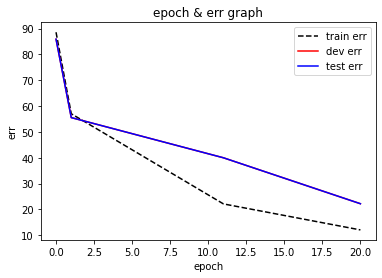

In [45]:
# 에포크에 따른 에러 그래프
# epoch-err curve
if (to_train):
    plt.plot(x_epoch, y_train_err, color = 'black', label = 'train err', linestyle = '--')
    plt.plot(x_epoch, y_dev_err, color = 'red', label = 'dev err')
    plt.plot(x_epoch, y_test_err, color='blue', label = 'test err')
    
    plt.xlabel('epoch')
    plt.ylabel('err')
    plt.title('epoch & err graph')
    plt.legend(loc="upper right")
    plt.show()

## 6. Evaluation for dev & test data

Normalized confusion matrix


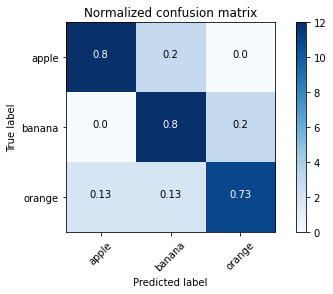

Confusion matrix, without normalization


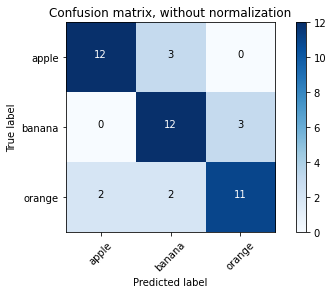

	 acc  |	 pre  |	 rec  |	 f1
 apple: 0.89 |	 0.86 |	 0.80 |	 0.83
 banana: 0.78 |	 0.71 |	 0.80 |	 0.75
 orange: 0.84 |	 0.79 |	 0.73 |	 0.76
*accuracy: 0.84, precision: 0.78, recall: 0.78, *f1 score: 0.78
[AP]
apple: 0.94
banana: 0.84
orange: 0.80

[mAP] 0.857
[miAP] 0.896


(array([0, 2, 2, 0, 1, 0, 0, 1, 0, 0, 1, 2, 2, 2, 1, 1, 2, 0, 1, 1, 1, 0,
        1, 2, 0, 0, 0, 0, 2, 1, 2, 2, 1, 1, 1, 0, 0, 1, 2, 1, 2, 1, 2, 2,
        1]),
 array([0, 2, 1, 0, 1, 0, 0, 2, 0, 0, 0, 2, 2, 2, 1, 1, 2, 2, 0, 1, 1, 2,
        1, 1, 0, 0, 0, 0, 2, 1, 2, 2, 1, 1, 0, 0, 0, 1, 2, 2, 2, 1, 2, 1,
        1]),
 array([0.87017077, 0.77844262, 0.53322881, 0.86297596, 0.68774921,
        0.78566974, 0.88121194, 0.53471595, 0.92156124, 0.65538096,
        0.46749783, 0.78342527, 0.4835231 , 0.75849628, 0.35285133,
        0.44941035, 0.69764578, 0.68575037, 0.53586048, 0.45363921,
        0.73100597, 0.40860155, 0.49585176, 0.52293187, 0.82792771,
        0.74489868, 0.85595012, 0.69415569, 0.45213887, 0.75470871,
        0.98436403, 0.84491891, 0.429203  , 0.82877463, 0.44203761,
        0.92540222, 0.87909806, 0.59110141, 0.45020938, 0.54244429,
        0.404295  , 0.72063816, 0.94377631, 0.49267668, 0.69329339]))

In [46]:
model.eval() # evaluation(test) mode 로 바꾸기 -> dropout, batch normalization
utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

Normalized confusion matrix


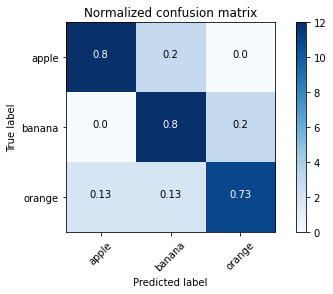

Confusion matrix, without normalization


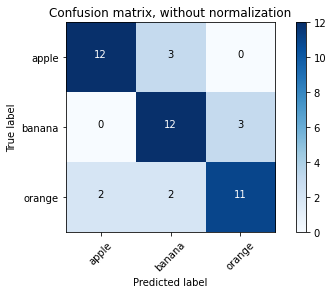

	 acc  |	 pre  |	 rec  |	 f1
 apple: 0.89 |	 0.86 |	 0.80 |	 0.83
 banana: 0.78 |	 0.71 |	 0.80 |	 0.75
 orange: 0.84 |	 0.79 |	 0.73 |	 0.76
*accuracy: 0.84, precision: 0.78, recall: 0.78, *f1 score: 0.78
[AP]
apple: 0.94
banana: 0.84
orange: 0.80

[mAP] 0.857
[miAP] 0.896


In [47]:
model.eval() # evaluation(test) mode 로 바꾸기 -> dropout, batch normalization
_, _,_ = utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

Category: apple
 True predicted images/total apple category: 12 / 15
Predicted probability:
[0.86297596 0.09461112 0.04241293]


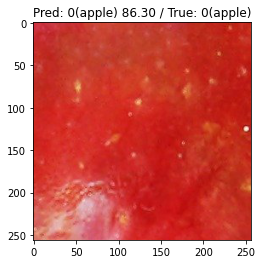

Predicted probability:
[0.88121194 0.07555436 0.04323371]


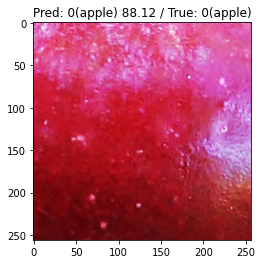

 False predicted images/total apple category: 3 / 15
Predicted probability:
[0.27913746 0.4420376  0.27882493]


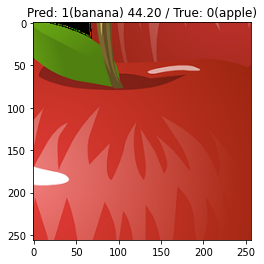

Predicted probability:
[0.3135879  0.5358605  0.15055157]


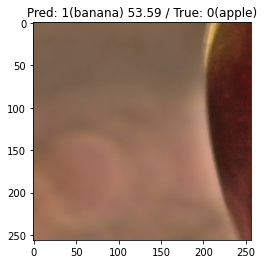

Category: banana
 True predicted images/total banana category: 12 / 15
Predicted probability:
[0.06916711 0.7547087  0.17612419]


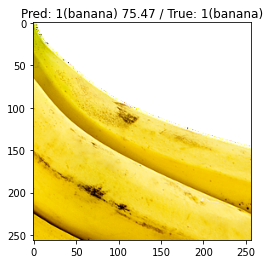

Predicted probability:
[0.31605467 0.429203   0.25474232]


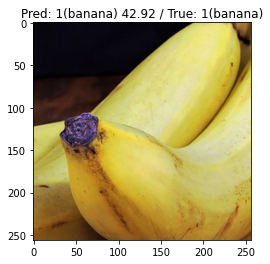

 False predicted images/total banana category: 3 / 15
Predicted probability:
[0.05941819 0.41764992 0.5229319 ]


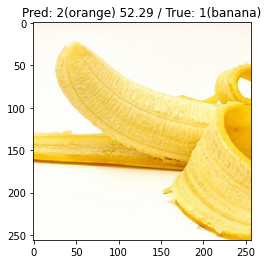

Predicted probability:
[0.22889607 0.27842727 0.49267668]


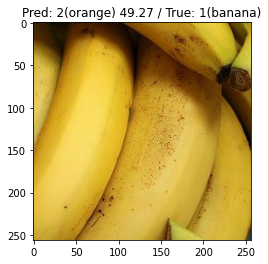

Category: orange
 True predicted images/total orange category: 11 / 15
Predicted probability:
[0.16130562 0.06025178 0.7784426 ]


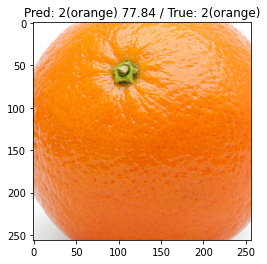

Predicted probability:
[0.1353641  0.10613959 0.7584963 ]


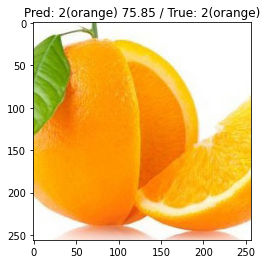

 False predicted images/total orange category: 4 / 15
Predicted probability:
[0.40860155 0.372236   0.21916243]


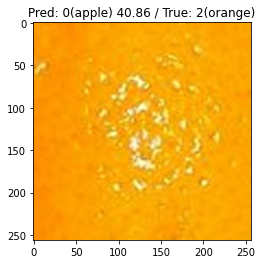

Predicted probability:
[0.68575037 0.20135124 0.11289842]


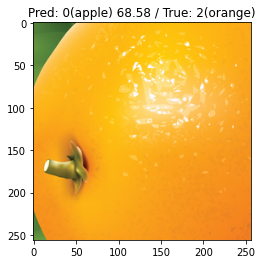

In [48]:
utils.VisTFPred(dev_batch, model,test_data.classes, batch_size, i_n=2)
# 각 클래스에 대한 결과값